# Chapter 10 - Recommender Systems Using Restricted Boltzmann Machines  (TensorFlow v 2.1.0)

## Setup

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

#### Check library versions & set seed

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    0.20.3
tensorflow 2.1.0
keras      2.2.4-tf
numpy      1.17.2


In [3]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

## Data Preparation

### MovieLens Dataset 

|MovieLens 20M Dataset||
|:------------|----------|
|ratings     |20,000,263| 
|movies      |27,278| 
|users       |138,493|

### Load the Data 

In [4]:
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratings.csv'])
ratingDF = pd.read_csv(current_path + file)

### Convert fields into appropriate data types 

In [5]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

Store DataFrame as pickle for faster loading in the future

In [6]:
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingPickle'])
ratingDF.to_pickle(current_path + pickle_file)
ratingDF = pd.read_pickle(current_path + pickle_file)

Preview data

In [7]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Calculate summary statistics on full dataset

In [8]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 138493
Number of unique movies: 26744
Number of total ratings: 20000263
Average number of ratings per user: 144.4


Reduce size of dataset by taking top 1000 movies

In [9]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= 
                "rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

Reduce size of dataset by sampling 1000 users

In [10]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= 
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

Reindex movie ID

In [11]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


Reindex user ID

In [12]:
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


Generate newly merged DataFrame

In [13]:
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId',
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', 
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


Save as pickle

In [14]:
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingReducedPickle'])
ratingDFX3.to_pickle(current_path + pickle_file)
ratingDFX3 = pd.read_pickle(current_path + pickle_file)

Calculate summary statistics on reduced dataset

In [15]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 1000
Number of unique movies: 1000
Number of total ratings: 90213
Average number of ratings per user: 90.2


Split into validation and test, such that each is 5% of the dataset

In [16]:
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, shuffle=True, random_state=2018)
X_valid, X_test = train_test_split(X_test,     test_size=0.50, shuffle=True, random_state=2018)

Confirm size of train, validation, and test datasets

In [17]:
for (l,x) in [('train',X_train),('validation',X_valid),('test',X_test)]:
    print(f'Size of {l} set: {len(x)}')

Size of train set: 81191
Size of validation set: 4511
Size of test set: 4511


## Define the cost Function: Mean Squared Error 

Generate ratings matrix for train, validation and test

In [18]:
ratings_train = np.zeros((n_users, n_movies))
ratings_valid = np.zeros((n_users, n_movies))
ratings_test  = np.zeros((n_users, n_movies))
for (X,ratings) in [(X_train,ratings_train),(X_valid,ratings_valid),(X_test,ratings_test)]:
    for row in X.itertuples():
        ratings[row[6]-1, row[5]-1] = row[3]

In [19]:
ratings_train.shape, ratings_valid.shape, ratings_test.shape

((1000, 1000), (1000, 1000), (1000, 1000))

Calculation the sprasity of the train, validation & test rationg matrices

In [20]:
def calc_sparsity(label, ratings):
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    print('{:s} Sparsity: {:4.2f}%'.format(label, sparsity))

In [21]:
for (lbl, rtg) in [('Train',ratings_train),('Validation',ratings_valid),('Test', ratings_test)]:
    calc_sparsity(lbl,rtg)

Train Sparsity: 8.12%
Validation Sparsity: 0.45%
Test Sparsity: 0.45%


## Perform Baseline Experiments 

Flatten the sprace matrix with the rations for the validation set. This will be the vector of actual ratings

In [22]:
actual_valid = ratings_valid[ratings_valid.nonzero()].flatten()

### Experiment One 
#### Assign naive 3.5 rating and calculate baseline MSE

In [23]:
pred_valid = np.zeros((len(X_valid),1))
pred_valid[pred_valid==0] = 3.5

In [24]:
naive_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using naive prediction: {round(naive_prediction,2)}')

Mean squared error using naive prediction: 1.06


### Experiment Two
#### Predict a user's rating based on user's average rating for all other movies

In [25]:
ratings_valid_pred = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

pred_valid = ratings_valid_pred[ratings_valid.nonzero()].flatten()
user_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using user average: {round(user_average,3)}')

Mean squared error using user average: 0.909


### Experiment Three
#### Predict a user's rating for a movie based on the average rating other users have given that movie 

In [26]:
ratings_valid_pred = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

ratings_valid_pred = ratings_valid_pred.T
pred_valid = ratings_valid_pred[ratings_valid.nonzero()].flatten()
movie_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using movie average: {round(movie_average,3)}')

Mean squared error using movie average: 0.914


## Matrix Factorization 

### Experiment Four - Recommender System using Matrix Factorization
#### One Latent Factor

In [27]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [28]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 2s 24us/sample - loss: 13.4436 - val_loss: 11.5197
Epoch 2/100
81191/81191 [==============================] - 2s 20us/sample - loss: 8.8163 - val_loss: 6.2817
Epoch 3/100
81191/81191 [==============================] - 2s 21us/sample - loss: 4.4879 - val_loss: 3.2602
Epoch 4/100
81191/81191 [==============================] - 2s 20us/sample - loss: 2.5015 - val_loss: 2.0229
Epoch 5/100
81191/81191 [==============================] - 2s 21us/sample - loss: 1.6251 - val_loss: 1.4304
Epoch 6/100
81191/81191 [==============================] - 2s 20us/sample - loss: 1.1894 - val_loss: 1.1305
Epoch 7/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.9683 - val_loss: 0.9748
Epoch 8/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.8552 - val_loss: 0.8942
Epoch 9/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.7

Epoch 76/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.7277 - val_loss: 0.7989
Epoch 77/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7278 - val_loss: 0.7980
Epoch 78/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7277 - val_loss: 0.7977
Epoch 79/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.7277 - val_loss: 0.7993
Epoch 80/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.7277 - val_loss: 0.7990
Epoch 81/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7277 - val_loss: 0.7975
Epoch 82/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.7278 - val_loss: 0.7970
Epoch 83/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7279 - val_loss: 0.7979
Epoch 84/100
81191/81191 [==============================] - 2s 20us/sample - loss: 0.7278 - val_loss: 0.7990
Epoch 85/100
81191/

Minimum MSE: 0.796


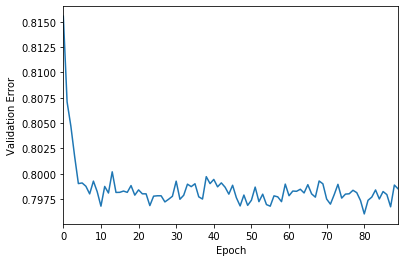

In [29]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

### Experiment Five - Recommender System using Matrix Factorization
#### Three Latent Factor

In [30]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(10e-7), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(10e-7), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [31]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
   32/81191 [..............................] - ETA: 9:07 - loss: 13.9572

/home/faisito/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/faisito/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


81191/81191 [==============================] - 2s 24us/sample - loss: 11.9497 - val_loss: 7.4388
Epoch 2/100
81191/81191 [==============================] - 2s 21us/sample - loss: 4.2506 - val_loss: 2.4705
Epoch 3/100
81191/81191 [==============================] - 2s 21us/sample - loss: 1.7421 - val_loss: 1.3478
Epoch 4/100
81191/81191 [==============================] - 2s 21us/sample - loss: 1.0710 - val_loss: 0.9941
Epoch 5/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.8546 - val_loss: 0.8717
Epoch 6/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7824 - val_loss: 0.8287
Epoch 7/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7571 - val_loss: 0.8119
Epoch 8/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7483 - val_loss: 0.8112
Epoch 9/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.7452 - val_loss: 0.8082
Epoch 10/100
81191/81191 [=============

81191/81191 [==============================] - 2s 21us/sample - loss: 0.6354 - val_loss: 0.7676
Epoch 77/100
81191/81191 [==============================] - 2s 22us/sample - loss: 0.6353 - val_loss: 0.7649
Epoch 78/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.6344 - val_loss: 0.7653
Epoch 79/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.6339 - val_loss: 0.7664
Epoch 80/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.6335 - val_loss: 0.7678
Epoch 81/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.6330 - val_loss: 0.7652
Epoch 82/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.6328 - val_loss: 0.7654
Epoch 83/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.6323 - val_loss: 0.7651
Epoch 84/100
81191/81191 [==============================] - 2s 21us/sample - loss: 0.6319 - val_loss: 0.7667
Epoch 85/100
81191/81191 [======

Minimum MSE: 0.763


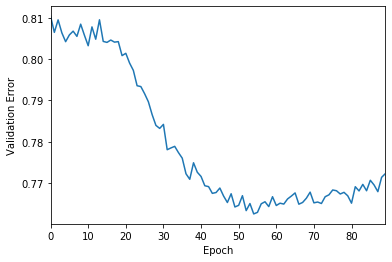

In [32]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

### Experiment Six - Recommender System using Matrix Factorization
#### Five Latent Factors

In [33]:
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(1e-6), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(1e-6), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [34]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId,X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
   32/81191 [..............................] - ETA: 9:33 - loss: 13.9529

/home/faisito/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/faisito/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


81191/81191 [==============================] - 2s 26us/sample - loss: 10.9793 - val_loss: 5.2609
Epoch 2/100
81191/81191 [==============================] - 2s 23us/sample - loss: 2.8429 - val_loss: 1.6763
Epoch 3/100
81191/81191 [==============================] - 2s 24us/sample - loss: 1.2204 - val_loss: 1.0329
Epoch 4/100
81191/81191 [==============================] - 2s 24us/sample - loss: 0.8697 - val_loss: 0.8709
Epoch 5/100
81191/81191 [==============================] - 2s 24us/sample - loss: 0.7818 - val_loss: 0.8257
Epoch 6/100
81191/81191 [==============================] - 2s 24us/sample - loss: 0.7590 - val_loss: 0.8135
Epoch 7/100
81191/81191 [==============================] - 2s 24us/sample - loss: 0.7520 - val_loss: 0.8076
Epoch 8/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.7500 - val_loss: 0.8123
Epoch 9/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.7494 - val_loss: 0.8104
Epoch 10/100
81191/81191 [=============

81191/81191 [==============================] - 2s 23us/sample - loss: 0.5627 - val_loss: 0.7959
Epoch 77/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5626 - val_loss: 0.7934
Epoch 78/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5616 - val_loss: 0.7944
Epoch 79/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5612 - val_loss: 0.7978
Epoch 80/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5608 - val_loss: 0.7973
Epoch 81/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5603 - val_loss: 0.7945
Epoch 82/100
81191/81191 [==============================] - 2s 24us/sample - loss: 0.5600 - val_loss: 0.7947
Epoch 83/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5596 - val_loss: 0.7953
Epoch 84/100
81191/81191 [==============================] - 2s 23us/sample - loss: 0.5591 - val_loss: 0.7980
Epoch 85/100
81191/81191 [======

Minimum MSE: 0.769


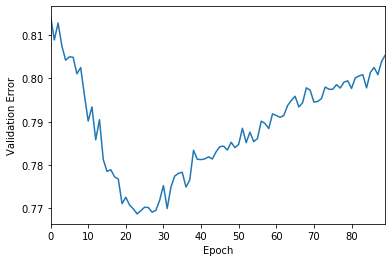

In [35]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

### Experiment Seven - Recommender System using RBMs

In [36]:
#make code compatible with v1 of TF
tf.compat.v1.disable_eager_execution()

In [37]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size])
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

Begin the training cycle

In [38]:
# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [39]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 1.111619
Epoch: 1 reconstruction error: 1.077608
Epoch: 2 reconstruction error: 1.090634
Epoch: 3 reconstruction error: 1.092777
Epoch: 4 reconstruction error: 1.094247
Epoch: 5 reconstruction error: 1.094252
Epoch: 6 reconstruction error: 1.090279
Epoch: 7 reconstruction error: 1.084947
Epoch: 8 reconstruction error: 1.086759
Epoch: 9 reconstruction error: 1.089347
Epoch: 10 reconstruction error: 1.089152
Epoch: 11 reconstruction error: 1.092489
Epoch: 12 reconstruction error: 1.089138
Epoch: 13 reconstruction error: 1.096748
Epoch: 14 reconstruction error: 1.090379
Epoch: 15 reconstruction error: 1.092049
Epoch: 16 reconstruction error: 1.096488
Epoch: 17 reconstruction error: 1.094620
Epoch: 18 reconstruction error: 1.093840
Epoch: 19 reconstruction error: 1.094844
Epoch: 20 reconstruction error: 1.096987
Epoch: 21 reconstruction error: 1.093371
Epoch: 22 reconstruction error: 1.095827
Epoch: 23 reconstruction error: 1.097365
Epoch: 24 reconstruction e

Epoch: 198 reconstruction error: 1.081575
Epoch: 199 reconstruction error: 1.080888
Epoch: 200 reconstruction error: 1.082314
Epoch: 201 reconstruction error: 1.081298
Epoch: 202 reconstruction error: 1.081427
Epoch: 203 reconstruction error: 1.080536
Epoch: 204 reconstruction error: 1.081583
Epoch: 205 reconstruction error: 1.081099
Epoch: 206 reconstruction error: 1.081509
Epoch: 207 reconstruction error: 1.080428
Epoch: 208 reconstruction error: 1.081316
Epoch: 209 reconstruction error: 1.081023
Epoch: 210 reconstruction error: 1.080940
Epoch: 211 reconstruction error: 1.080698
Epoch: 212 reconstruction error: 1.080750
Epoch: 213 reconstruction error: 1.080737
Epoch: 214 reconstruction error: 1.081004
Epoch: 215 reconstruction error: 1.080549
Epoch: 216 reconstruction error: 1.080842
Epoch: 217 reconstruction error: 1.080484
Epoch: 218 reconstruction error: 1.080767
Epoch: 219 reconstruction error: 1.080176
Epoch: 220 reconstruction error: 1.080750
Epoch: 221 reconstruction error: 1

Epoch: 394 reconstruction error: 1.075943
Epoch: 395 reconstruction error: 1.075513
Epoch: 396 reconstruction error: 1.075611
Epoch: 397 reconstruction error: 1.075719
Epoch: 398 reconstruction error: 1.075621
Epoch: 399 reconstruction error: 1.075215
Epoch: 400 reconstruction error: 1.075688
Epoch: 401 reconstruction error: 1.075560
Epoch: 402 reconstruction error: 1.075245
Epoch: 403 reconstruction error: 1.075241
Epoch: 404 reconstruction error: 1.075372
Epoch: 405 reconstruction error: 1.075228
Epoch: 406 reconstruction error: 1.075359
Epoch: 407 reconstruction error: 1.075374
Epoch: 408 reconstruction error: 1.075281
Epoch: 409 reconstruction error: 1.075446
Epoch: 410 reconstruction error: 1.075416
Epoch: 411 reconstruction error: 1.075279
Epoch: 412 reconstruction error: 1.075541
Epoch: 413 reconstruction error: 1.075837
Epoch: 414 reconstruction error: 1.075328
Epoch: 415 reconstruction error: 1.075719
Epoch: 416 reconstruction error: 1.075711
Epoch: 417 reconstruction error: 1

Epoch: 590 reconstruction error: 1.072567
Epoch: 591 reconstruction error: 1.072875
Epoch: 592 reconstruction error: 1.071919
Epoch: 593 reconstruction error: 1.072741
Epoch: 594 reconstruction error: 1.072590
Epoch: 595 reconstruction error: 1.072708
Epoch: 596 reconstruction error: 1.072204
Epoch: 597 reconstruction error: 1.072448
Epoch: 598 reconstruction error: 1.072508
Epoch: 599 reconstruction error: 1.072505
Epoch: 600 reconstruction error: 1.072227
Epoch: 601 reconstruction error: 1.072860
Epoch: 602 reconstruction error: 1.072490
Epoch: 603 reconstruction error: 1.072320
Epoch: 604 reconstruction error: 1.072657
Epoch: 605 reconstruction error: 1.072494
Epoch: 606 reconstruction error: 1.072194
Epoch: 607 reconstruction error: 1.072358
Epoch: 608 reconstruction error: 1.072512
Epoch: 609 reconstruction error: 1.072263
Epoch: 610 reconstruction error: 1.072106
Epoch: 611 reconstruction error: 1.073311
Epoch: 612 reconstruction error: 1.072098
Epoch: 613 reconstruction error: 1

Epoch: 786 reconstruction error: 1.070451
Epoch: 787 reconstruction error: 1.070573
Epoch: 788 reconstruction error: 1.070289
Epoch: 789 reconstruction error: 1.070712
Epoch: 790 reconstruction error: 1.070081
Epoch: 791 reconstruction error: 1.070691
Epoch: 792 reconstruction error: 1.070153
Epoch: 793 reconstruction error: 1.070598
Epoch: 794 reconstruction error: 1.070354
Epoch: 795 reconstruction error: 1.070444
Epoch: 796 reconstruction error: 1.070575
Epoch: 797 reconstruction error: 1.070601
Epoch: 798 reconstruction error: 1.070485
Epoch: 799 reconstruction error: 1.070390
Epoch: 800 reconstruction error: 1.070776
Epoch: 801 reconstruction error: 1.070904
Epoch: 802 reconstruction error: 1.070390
Epoch: 803 reconstruction error: 1.070922
Epoch: 804 reconstruction error: 1.070719
Epoch: 805 reconstruction error: 1.070490
Epoch: 806 reconstruction error: 1.070546
Epoch: 807 reconstruction error: 1.070500
Epoch: 808 reconstruction error: 1.070359
Epoch: 809 reconstruction error: 1

Epoch: 982 reconstruction error: 1.069870
Epoch: 983 reconstruction error: 1.070230
Epoch: 984 reconstruction error: 1.069927
Epoch: 985 reconstruction error: 1.069474
Epoch: 986 reconstruction error: 1.069867
Epoch: 987 reconstruction error: 1.069734
Epoch: 988 reconstruction error: 1.069898
Epoch: 989 reconstruction error: 1.069607
Epoch: 990 reconstruction error: 1.070014
Epoch: 991 reconstruction error: 1.069523
Epoch: 992 reconstruction error: 1.069991
Epoch: 993 reconstruction error: 1.069834
Epoch: 994 reconstruction error: 1.069958
Epoch: 995 reconstruction error: 1.069993
Epoch: 996 reconstruction error: 1.069689
Epoch: 997 reconstruction error: 1.069693
Epoch: 998 reconstruction error: 1.069870
Epoch: 999 reconstruction error: 1.070186


Plot reconstruction errors

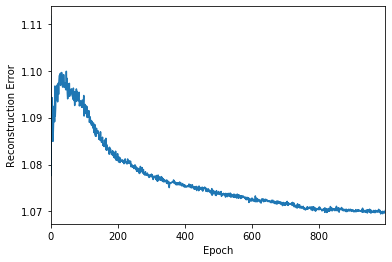

In [40]:
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error");

Predict ratings for validation set

In [41]:
inputValid = ratings_valid
inputValid = inputValid.astype(np.float32)

_, reconstructedOutput_valid, _ = rbm.rbm_output(inputValid)

Calculate MSE on validation set

In [42]:
predictionsArray = reconstructedOutput_valid
pred_valid = predictionsArray[ratings_valid.nonzero()].flatten()
actual_valid = ratings_valid[ratings_valid.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using RBM prediction: {round(rbm_prediction,2)}')

Mean squared error using RBM prediction: 9.33
